In [57]:
import math
import random
import matplotlib.pyplot as plt
import time
import statistics
import numpy as np

**GENERATE CUSTOMERS, DEMAND, COST_MATRIX FUNCTION**

In [58]:
# ---- Generate Random customers and Demands ----
def generate_customers(num_customers):
    """Tạo danh sách khách hàng với tọa độ ngẫu nhiên"""
    customers = [(random.uniform(0, 10), random.uniform(0, 10)) for _ in range(num_customers + 1)]  # +1 for depot
    return customers
# ---- Distance and Cost Matrix Functions ----
def distance(customer1, customer2):
    return math.hypot(customer1[0] - customer2[0], customer1[1] - customer2[1])

def create_symmetric_cost_matrix(customers):
    n = len(customers)
    cost_matrix = np.zeros((n, n))
   
    for i in range(n):
        for j in range(n):
            if i != j:  # Không tính khoảng cách từ khách hàng đến chính nó
                cost_matrix[i][j] = distance(customers[i], customers[j]) 
    return cost_matrix

# Function để tạo asymmetric TSP (chi phí AB ≠ BA)
def create_asymmetric_cost_matrix(cost_matrix, asymmetric_percentage=0.3, max_factor=2.0, use_asymmetric=True):
    if not use_asymmetric:
        return cost_matrix
       
    n = len(cost_matrix)
    asymmetric_count = int((n * (n-1) / 2) * asymmetric_percentage)  # percentage% cạnh sẽ có chi phí khác nhau theo hướng
   
    # Clone ma trận gốc
    new_matrix = cost_matrix.copy()
   
    # Danh sách các cạnh có thể chọn (không bao gồm đường chéo chính)
    edges = [(i, j) for i in range(n) for j in range(i+1, n)]
   
    # Chọn ngẫu nhiên các cạnh để tạo đường một chiều
    selected_edges = random.sample(edges, asymmetric_count)
   
    for i, j in selected_edges:
        # Đảm bảo cost không bị thay đổi quá nhiều so với cost gốc
        original_cost = new_matrix[i][j]
       
        # Chọn ngẫu nhiên một trong hai chiều để thay đổi
        if random.choice([True, False]):
            new_matrix[i][j] = original_cost * random.uniform(1.0 / max_factor, max_factor)
        else:
            new_matrix[j][i] = original_cost * random.uniform(1.0 / max_factor, max_factor)
   
    return new_matrix

**PROBLEM CREATING FUNCTION**

In [59]:
def create_problem(
    custom_customer_map,
    custom_customer_map_mode,
    custom_cost_matrix,
    custom_cost_matrix_mode,
    num_customers,
    asymmetric_percentage=0.3,
    use_asymmetric=False,
    max_factor = 2.0,
    random_seed=None
):
    # Thiết lập seed để tái tạo kết quả (nếu cần)
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
    if custom_customer_map_mode:
        customers = custom_customer_map
    else:
        customers= generate_customers(num_customers)
    if custom_cost_matrix_mode:
        cost_matrix= custom_cost_matrix
    else:
        # Tạo ma trận khoảng cách gốc (đối xứng)
        cost_matrix = create_symmetric_cost_matrix(customers)
        # Áp dụng bất đối xứng nếu có
        cost_matrix = create_asymmetric_cost_matrix(
            cost_matrix,
            asymmetric_percentage=asymmetric_percentage,
            max_factor=max_factor,
            use_asymmetric=use_asymmetric
        )
        cost_matrix *= 10000
    return customers, cost_matrix

**COST CALCULATING FUNCTION**

In [60]:
# ---- VRP Solution Representation and Evaluation ----
#Tính tổng chi phí
def total_distance(solution, cost_matrix, depot=0):
    total_cost = 0
   
    for route in solution:
        if not route:  # Bỏ qua route rỗng
            continue
           
        # Tính chi phí từ kho đến điểm đầu tiên trong route
        current_cost = cost_matrix[depot][route[0]]
       
        # Tính chi phí giữa các điểm trong route
        for i in range(len(route) - 1):
            current_cost += cost_matrix[route[i]][route[i + 1]]
       
        # Tính chi phí từ điểm cuối cùng trở về kho
        current_cost += cost_matrix[route[-1]][depot]
       
        total_cost += current_cost
   
    return total_cost

**INITIAL SOLUTION CREATING FUNCTIONS**

In [61]:
def initial_solution_generation_random(num_customers, num_vehicles):
    customers = list(range(1, num_customers + 1))  # Bỏ depot
    random.shuffle(customers)

    # Chia đều khách hàng cho các xe
    initial_solution = [[] for _ in range(num_vehicles)]
    for i, customer in enumerate(customers):
        initial_solution[i % num_vehicles].append(customer)

    return initial_solution


def initial_solution_generation_NN(cost_matrix, num_customers, num_vehicles, depot=0):
    unvisited = set(range(1, num_customers + 1))  # Không bao gồm depot
    initial_solution = [[] for _ in range(num_vehicles)]

    vehicle_idx = 0
    while unvisited:
        # Vị trí hiện tại của xe: nếu chưa đi đâu thì ở depot
        current = depot if not initial_solution[vehicle_idx] else initial_solution[vehicle_idx][-1]

        # Tìm khách hàng gần nhất chưa đi
        next_customer = None
        min_dist = float('inf')

        for customer in unvisited:
            dist = cost_matrix[current][customer]
            if dist < min_dist:
                min_dist = dist
                next_customer = customer

        # Thêm vào route của xe hiện tại
        if next_customer is not None:
            initial_solution[vehicle_idx].append(next_customer)
            unvisited.remove(next_customer)

        # Chuyển sang xe tiếp theo
        vehicle_idx = (vehicle_idx + 1) % num_vehicles

    return initial_solution

**SWAPPING FUNCTIONS**

In [62]:
def swap_within_route(solution): #Đổi 2 khách cùng route
    new_solution = [route[:] for route in solution]
   
    # Chọn ngẫu nhiên một route không rỗng
    non_empty_routes = [i for i, route in enumerate(new_solution) if len(route) >= 2]
    if not non_empty_routes:
        return new_solution
   
    route_idx = random.choice(non_empty_routes)
    route = new_solution[route_idx]
   
    # Chọn hai vị trí ngẫu nhiên trong route
    pos1, pos2 = random.sample(range(len(route)), 2)
   
    # Hoán đổi
    route[pos1], route[pos2] = route[pos2], route[pos1]
   
    return new_solution


def two_opt_within_route(solution):#2opt trong cùng route
    new_solution = [route[:] for route in solution]
   
    # Chọn ngẫu nhiên một route có ít nhất 3 khách hàng
    valid_routes = [i for i, route in enumerate(new_solution) if len(route) >= 3]
    if not valid_routes:
        return new_solution
   
    route_idx = random.choice(valid_routes)
    route = new_solution[route_idx]
   
    # Chọn hai vị trí ngẫu nhiên
    i, j = sorted(random.sample(range(len(route)), 2))
   
    # Đảo ngược đoạn từ i đến j
    new_solution[route_idx] = route[:i] + route[i:j+1][::-1] + route[j+1:]
   
    return new_solution

def swap_between_routes(solution):#Đổi 2 khách giữa 2 route
    new_solution = [route[:] for route in solution]

    non_empty_routes = [i for i, route in enumerate(new_solution) if route]
    if len(non_empty_routes) < 2:
        return new_solution

    route1_idx, route2_idx = random.sample(non_empty_routes, 2)
    route1, route2 = new_solution[route1_idx], new_solution[route2_idx]

    customer1_idx = random.randrange(len(route1))
    customer2_idx = random.randrange(len(route2))

    route1[customer1_idx], route2[customer2_idx] = route2[customer2_idx], route1[customer1_idx]

    return new_solution

def move_customer(solution):#Đưa ngẫu nhiên khách từ route này sang route khác
    new_solution = [route[:] for route in solution]

    non_empty_routes = [i for i, route in enumerate(new_solution) if route]
    if not non_empty_routes:
        return new_solution

    from_route_idx = random.choice(non_empty_routes)
    from_route = new_solution[from_route_idx]

    other_routes = [i for i in range(len(new_solution)) if i != from_route_idx]
    if not other_routes:
        return new_solution

    to_route_idx = random.choice(other_routes)

    customer_idx = random.randrange(len(from_route))
    customer = from_route.pop(customer_idx)

    insert_pos = random.randint(0, len(new_solution[to_route_idx]))
    new_solution[to_route_idx].insert(insert_pos, customer)

    return new_solution

**PLOT CREATING FUNCTION**

In [63]:
def plot_solution(solution, customers, best_cost, iterations, execution_time,
                  num_vehicles, initial_temp, cooling_rate, stopping_temp, max_iter,
                  depot=0, initialization_method='random', cooling_strategy='exponential'):
    plt.figure(figsize=(14, 10))
    colors = plt.cm.tab10(np.linspace(0, 1, num_vehicles))

    # Vẽ các điểm
    for i, (x, y) in enumerate(customers):
        if i == depot:
            plt.scatter(x, y, c='red', s=500, marker='*', edgecolors='black', zorder=3)
            plt.text(x + 0.2, y + 0.2, "Depot", fontsize=14, ha='center', va='bottom', fontweight='bold')
        else:
            plt.scatter(x, y, c='lightgray', s=100, edgecolors='black', zorder=2)
            plt.text(x + 0.2, y + 0.2, f"{i}", fontsize=12, fontweight='bold', ha='left', va='bottom')

    # Vẽ route và mũi tên
    for v, route in enumerate(solution):
        if not route:
            continue
        color = colors[v % len(colors)]

        # Từ depot đến điểm đầu tiên
        x0, y0 = customers[depot]
        x1, y1 = customers[route[0]]
        plt.plot([x0, x1], [y0, y1], c=color, linestyle='-', linewidth=2, alpha=0.7, zorder=1)
        plt.arrow(x0, y0, (x1 - x0) * 0.8, (y1 - y0) * 0.8, color=color, width=0.03, head_width=0.15, length_includes_head=True, alpha=0.75)

        # Các điểm trong route
        for i in range(len(route) - 1):
            x0, y0 = customers[route[i]]
            x1, y1 = customers[route[i + 1]]
            plt.plot([x0, x1], [y0, y1], c=color, linestyle='-', linewidth=2, alpha=0.7, zorder=1)
            plt.arrow(x0, y0, (x1 - x0) * 0.8, (y1 - y0) * 0.8, color=color, width=0.03, head_width=0.15, length_includes_head=True, alpha=0.75)

        # Từ điểm cuối về depot
        x0, y0 = customers[route[-1]]
        x1, y1 = customers[depot]
        plt.plot([x0, x1], [y0, y1], c=color, linestyle='-', linewidth=2, alpha=0.7, zorder=1)
        plt.arrow(x0, y0, (x1 - x0) * 0.8, (y1 - y0) * 0.8, color=color, width=0.03, head_width=0.15, length_includes_head=True, alpha=0.75)

        # Ghi nhãn tuyến đường
        if route:
            mid_customer = route[len(route) // 2]
            mx, my = customers[mid_customer]
            plt.text(mx, my + 0.5,
                     f"Route {v + 1}", fontsize=14, ha='center', va='center',
                     bbox=dict(facecolor=color, alpha=0.3, boxstyle='round'))

    # Tiêu đề và chú thích
    plt.title(
        f'$\\mathbf{{mTSP\\ Solution}}$\n'
        f'$\\mathbf{{Best Cost}}$: {round(best_cost, 2)}, $\\mathbf{{Iterations}}$: {iterations}, '
        f'$\\mathbf{{Time}}$: {execution_time}s\n'
        f'$\\mathbf{{Vehicles}}$: {num_vehicles} | '
        f'$\\mathbf{{Init Method}}$: {initialization_method} | '
        f'$\\mathbf{{Cooling Strategy}}$: {cooling_strategy} | '
        f'$\\mathbf{{Cooling Rate}}$: {cooling_rate} | '
        f'$\\mathbf{{Initial Temp}}$: {round(initial_temp, 2)} | '
        f'$\\mathbf{{Stopping Temp}}$: {stopping_temp} | '
        f'$\\mathbf{{Max Iter}}$: {max_iter}',
        fontsize=12, ha='center'
    )

    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


In [64]:
def plot_time_and_cost(compare_cost,avg_cost,best_cost,worst_cost,std_cost,
                       compare_time,avg_time,best_time,worst_time,std_time):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(compare_cost, color='blue', marker='o')
    plt.title('Cost per Run\n' +
              f'Avg: {round(avg_cost,2)} | Best: {round(best_cost,2)} | Worst: {round(worst_cost,2)} | Std: {round(std_cost,2)}')
    plt.xlabel('Run')
    plt.ylabel('Cost')

    plt.subplot(1, 2, 2)
    plt.plot(compare_time, color='red', marker='o')
    plt.title('Time per Run\n' +
              f'Avg: {round(avg_time,2)}s | Best: {round(best_time,2)}s | Worst: {round(worst_time,2)}s | Std: {round(std_time,2)}s')
    plt.xlabel('Run')
    plt.ylabel('Time (s)')

    plt.tight_layout()
    plt.show()

**AUTO INITIAL TEMP FUNCTION**

In [65]:
def generate_positive_transitions(sample_size, cost_matrix, num_customers, num_vehicles, depot, initialization_method,operator_mode,chosen_operator):
    transitions = []
    while len(transitions) < sample_size: #Lặp tới khi đạt được sample_size mong muốn
        # Khởi tạo giải pháp ban đầu
        if initialization_method == 'nn':
            current_solution = initial_solution_generation_NN(cost_matrix, num_customers, num_vehicles, depot)
        else:
            current_solution = initial_solution_generation_random(num_customers, num_vehicles)

        current_cost = total_distance(current_solution, cost_matrix, depot)

        neighbor_operators = [
            lambda sol: swap_within_route(sol),
            lambda sol: two_opt_within_route(sol),
            lambda sol: swap_between_routes(sol),
            lambda sol: move_customer(sol)        
        ]

        if operator_mode == "random":
            neighbor_operator = random.choice(neighbor_operators)
        else:
            neighbor_operator = neighbor_operators[chosen_operator]

        new_solution = neighbor_operator(current_solution)
        new_cost = total_distance(new_solution, cost_matrix, depot)

        #Lưu nếu là transition dương
        if new_cost > current_cost:
            transitions.append((current_cost, new_cost))

    return transitions

def compute_initial_temp(transitions, desired_accept_prob=0.8, acceptable_error=0.01, p=1.0, initial_temp=1000.0, max_iter=100):
    T = initial_temp
    n = 1

    while n < max_iter:
        numerator = sum(math.exp(-e2 / T) for (_, e2) in transitions)
        denominator = sum(math.exp(-e1 / T) for (e1, _) in transitions)

        # Kiểm tra tránh chia cho 0
        if denominator == 0:
            T *= 10  # Tăng T lên để giá trị exp() không tiến về 0
            continue

        accept_prob = numerator / denominator

        # Kiểm tra hội tụ
        if abs(accept_prob - desired_accept_prob)/ desired_accept_prob <= acceptable_error:
            return T

        # Tính log_ratio và cập nhật T
        try:
            log_ratio = math.log(accept_prob) / math.log(desired_accept_prob)
            T = T * (log_ratio ** (1 / p))
        except (ValueError, ZeroDivisionError):
            # Nếu gặp log(0) hoặc chia 0, tăng T lên để thử lại
            T *= 10
            continue
        n += 1

    return T

    

**SIMULATED ANNEALING FUNCTION**

In [66]:
def simulated_annealing_mtsp(
    num_customers,
    num_vehicles,
    cost_matrix,
    initial_temp=1000,
    cooling_rate=0.995,
    stopping_temp=1e-8,
    max_iter=100000,
    operator_mode='random', 
    chosen_operator=3,
    depot=0,
    initialization_method='random',
    cooling_strategy='exponential'
):
    # Khởi tạo giải pháp ban đầu
    if initialization_method == 'nn':
        current_solution = initial_solution_generation_NN(cost_matrix, num_customers, num_vehicles, depot)
    else:
        current_solution = initial_solution_generation_random(num_customers, num_vehicles)

    current_cost = total_distance(current_solution, cost_matrix, depot)
    best_solution = [route[:] for route in current_solution]
    best_cost = current_cost

    neighbor_operators = [
        lambda sol: swap_within_route(sol),
        lambda sol: two_opt_within_route(sol),
        lambda sol: swap_between_routes(sol),
        lambda sol: move_customer(sol) 
    ]    

    iteration = 0
    temp=initial_temp

    while iteration < max_iter and temp > stopping_temp:
        iteration += 1

        if operator_mode == "random":
            neighbor_operator = random.choice(neighbor_operators)
        else:
            neighbor_operator = neighbor_operators[chosen_operator]

        new_solution = neighbor_operator(current_solution)
        new_cost = total_distance(new_solution, cost_matrix, depot)

        delta = new_cost - current_cost
        if delta < 0 or random.random() < math.exp(-delta / temp):
            current_solution = new_solution
            current_cost = new_cost
            if current_cost < best_cost:
                best_solution = [route[:] for route in current_solution]
                best_cost = current_cost

        if cooling_strategy == 'exponential':
            temp *= cooling_rate
        elif cooling_strategy == 'linear':
            temp -= cooling_rate
        elif cooling_strategy == 'logarithmic':
            temp = initial_temp / (1 + cooling_rate * math.log(1 + iteration))

    return best_solution, best_cost, iteration

**WHOLE PROCESS**

In [67]:
def run_simulation(
    custom_customer_map = [],
    custom_customer_map_mode = False,
    custom_cost_matrix = [],
    custom_cost_matrix_mode = False,
    num_customers=30,
    num_vehicles=4,
    asymmetric_percentage = 0.3,
    use_asymmetric=False,
    max_factor = 2.0,
    auto_initial_temp = True,
    sample_size = 100,
    desired_accept_prob=0.9, 
    acceptable_error=0.01, 
    p=1.0,
    max_iter_temp = 100,
    initial_temp=1000,
    cooling_rate=0.995,
    stopping_temp=1e-8,
    max_iter=100000,
    depot=0,
    initialization_method='random',
    cooling_strategy='exponential',
    operator_mode='random',
    chosen_operator=None,
    random_seed=None
):
    if custom_customer_map_mode:
        num_customers = len(custom_customer_map)-1
        
    customers, cost_matrix = create_problem(
    custom_customer_map,
    custom_customer_map_mode,
    custom_cost_matrix ,
    custom_cost_matrix_mode,
    num_customers,
    asymmetric_percentage,
    use_asymmetric,
    max_factor,
    random_seed
)
    random.seed()
    np.random.seed()

    #Tính initial_temp tự động
    if auto_initial_temp:
        transitions = generate_positive_transitions(sample_size, cost_matrix, num_customers, num_vehicles, depot, initialization_method,operator_mode,chosen_operator) 
        initial_temp = compute_initial_temp(transitions, desired_accept_prob, acceptable_error, p, initial_temp, max_iter_temp)
    print(f"Auto Initial Temp: {round(initial_temp,2)}")
    
    compare_cost = []
    compare_time = []
    compare_solutions = []

    num_runs=50

    for i in range(num_runs):
        start_time = time.time()

        best_solution, best_cost, iterations = simulated_annealing_mtsp(
            num_customers=num_customers,
            num_vehicles=num_vehicles,
            cost_matrix=cost_matrix,
            initial_temp=initial_temp,
            cooling_rate=cooling_rate,
            stopping_temp=stopping_temp,
            max_iter=max_iter,
            operator_mode=operator_mode,
            chosen_operator=chosen_operator,
            depot=depot,
            initialization_method=initialization_method,
            cooling_strategy=cooling_strategy
        )
        execution_time = round(time.time() - start_time, 4)
        compare_cost.append(best_cost)
        compare_time.append(execution_time)
        compare_solutions.append(best_solution)

    # Tính toán thống kê
    avg_cost = sum(compare_cost) / num_runs
    best_cost = min(compare_cost)
    worst_cost = max(compare_cost)
    std_cost = statistics.stdev(compare_cost)

    avg_time = sum(compare_time) / num_runs
    best_time = min(compare_time)
    worst_time = max(compare_time)
    std_time = statistics.stdev(compare_time)

    # Tìm best_solution theo best_cost
    best_index = compare_cost.index(best_cost)
    best_solution_final = compare_solutions[best_index]

    # # In kết quả
    # print("\n===== SIMULATED ANNEALING SUMMARY =====")
    # print(f"Runs: {num_runs}")
    print(f"Best cost: {round(best_cost, 2)}")
    print(f"Worst cost: {round(worst_cost, 2)}")
    print(f"Avg cost: {round(avg_cost, 2)}")
    print(f"Std cost: {round(std_cost, 2)}")

    print(f"\nBest time: {round(best_time, 4)} s")
    print(f"Worst time: {round(worst_time, 4)} s")
    print(f"Avg time: {round(avg_time, 4)} s")
    print(f"Std time: {round(std_time, 4)} s")

    print("\nBest solution routes:")
    for i, route in enumerate(best_solution_final):
        print(f"  Vehicle {i+1}: {depot} -> {' -> '.join(map(str, route))} -> {depot}")

    plot_time_and_cost(compare_cost,avg_cost,best_cost,worst_cost,std_cost,
                       compare_time,avg_time,best_time,worst_time,std_time)
    plot_solution(
        best_solution_final, customers, best_cost, iterations, execution_time,
        num_vehicles, initial_temp, cooling_rate, stopping_temp, max_iter,
        depot, initialization_method, cooling_strategy
    )

    return best_solution_final, best_cost, customers, cost_matrix


In [68]:
# def plot_temp(temps_exponential,temps_linear,temps_logarithmic):
#     plt.figure(figsize=(10, 6))
#     plt.plot(temps_exponential, label="Exponential Cooling", color='blue')
#     plt.plot(temps_linear, label="Linear Cooling", color='green')
#     plt.plot(temps_logarithmic, label="Logarithmic Cooling", color='red')
#     plt.xlabel("Iteration")
#     plt.ylabel("Temperature")
#     plt.title("Cooling Schedules Comparison (Initial T = 1000)")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# def run_simulation_temp():
#     strategies = ['exponential', 'linear', 'logarithmic']
#     temp_log = {}
#     initial_temp = 2000
#     max_iter = 500

#     for strategy in strategies:
#         temp = initial_temp
#         temperatures = [temp]

#         for iteration in range(1, max_iter + 1):
#             if strategy == 'exponential':
#                 temp *= 0.9862
#             elif strategy == 'linear':
#                 temp -= 4.0
#             elif strategy == 'logarithmic':
#                 temp = initial_temp / (1 + math.log(1 + iteration))
#             temperatures.append(temp)

#         temp_log[strategy] = temperatures

#     # Vẽ biểu đồ
#     plot_temp(
#         temp_log['exponential'],
#         temp_log['linear'],   
#         temp_log['logarithmic']
#     )
#     return temp_log


**MAIN**

Auto Initial Temp: 1000
Best cost: 431768.11
Worst cost: 575649.17
Avg cost: 506275.27
Std cost: 35850.45

Best time: 0.1838 s
Worst time: 0.2595 s
Avg time: 0.2051 s
Std time: 0.0163 s

Best solution routes:
  Vehicle 1: 0 ->  -> 0
  Vehicle 2: 0 -> 9 -> 8 -> 14 -> 13 -> 6 -> 2 -> 3 -> 1 -> 0
  Vehicle 3: 0 -> 7 -> 12 -> 10 -> 11 -> 5 -> 4 -> 15 -> 0


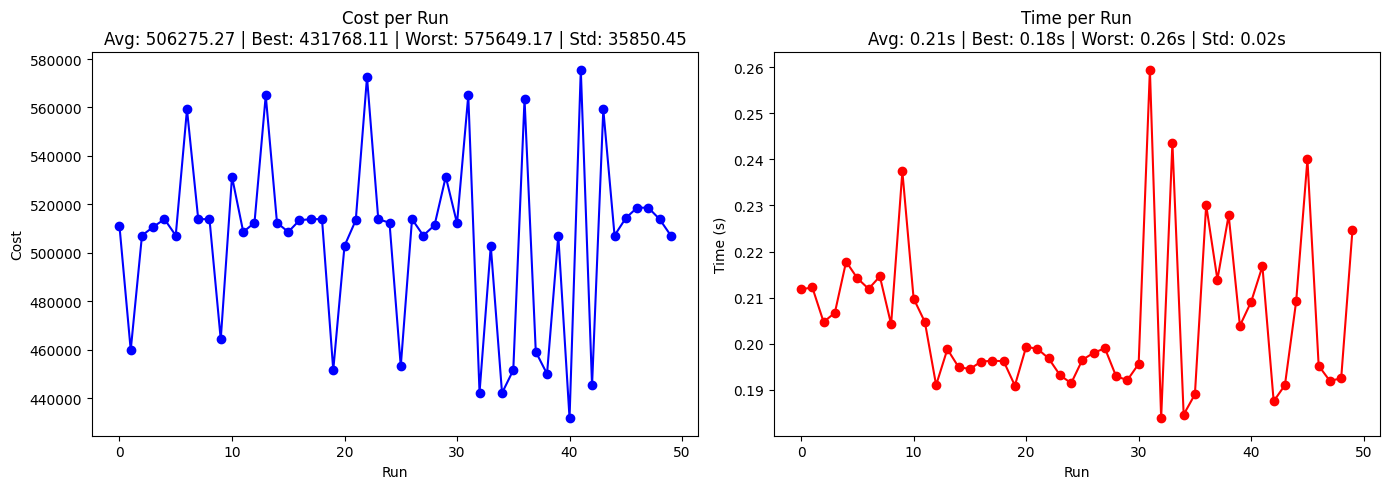

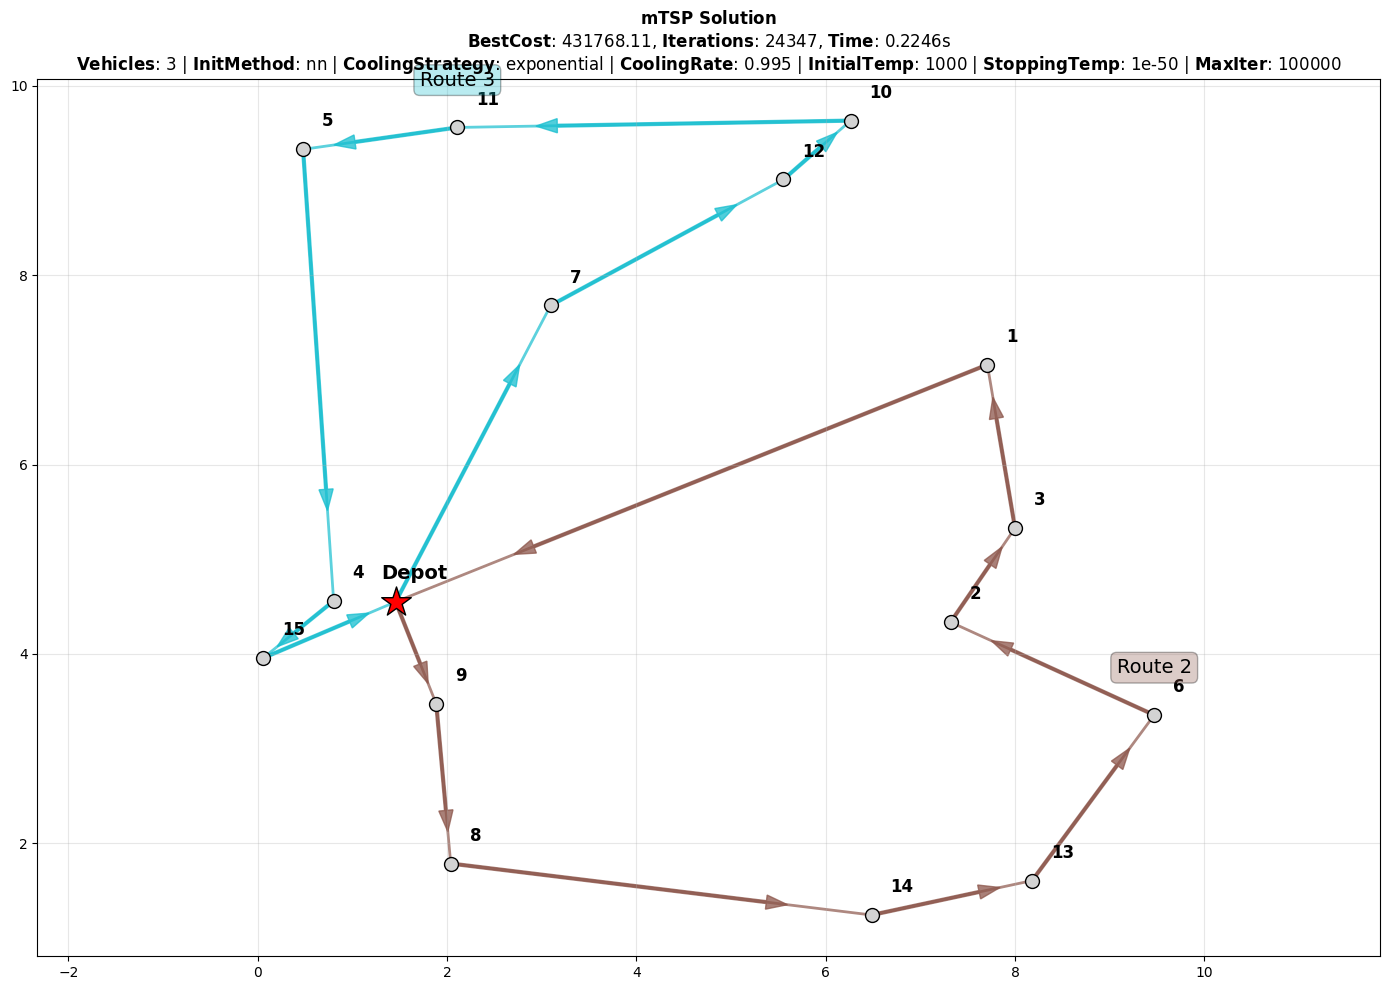

In [71]:
# ---- Main Execution ----
if __name__ == "__main__":
    # Run with default parameters
        run_simulation(
        custom_customer_map = [],
        custom_customer_map_mode = False,
        custom_cost_matrix=[],
        custom_cost_matrix_mode=False,
        num_customers=15,
        num_vehicles=3,
        asymmetric_percentage = 0.25,
        use_asymmetric=True,
        max_factor = 2.0,
        auto_initial_temp = False,
        sample_size = 100,
        desired_accept_prob=0.8, 
        acceptable_error=0.01, 
        p=1.0,
        max_iter_temp = 100,
        initial_temp=1000,
        cooling_rate=0.995,
        stopping_temp=1e-50,
        max_iter=100000,
        depot=0,
        initialization_method='nn',
        cooling_strategy='exponential',
        operator_mode="random",
        chosen_operator=3,
        random_seed=100
        )
